<a href="https://colab.research.google.com/github/Lirikman/neural_networks/blob/main/computer%20vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Keras v3. Современные подходы к CV (компьютерное зрение)](https://colab.research.google.com/drive/16ks3VjO38c7N4kXUsrdzUbunJOxRu3Fq)
2. [Перенос обучения в Keras 3.0](https://colab.research.google.com/drive/1x2qd4MvG3ODgNrE2uqxRAZB70dGgdGft)
3. [Знакомство с KerasCV](https://colab.research.google.com/drive/1ZWfrEDQaQqDmVUF0yk7N4yoMHRkXf9K-)
4. Домашняя работа

В домашней работе вам необходимо, используя пример из урока 19.2 и Keras 3, произвести тонкую настройку модели второй версии [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

Баллы за задание начисляются следующим образом:
* 3 балла - дается за успешно выполненное задание с точностью на проверочной выборке не менее 75%, в задании должна быть проведена аугментация данных.
* Для получения 4-х баллов необходимо добиться, чтобы точности на проверочной и тестовой выборках были выше 75%.
* Для получения 5-ти баллов необходимо случайным образом отобрать 10 пород собак, выполнить аугментацию и добиться точности как на обучающей, так и проверочной выборках более 85%.  

**Примечание**. В 2021 году появилась вторая версия модели EfficientNetV2 (https://arxiv.org/pdf/2104.00298.pdf), которая была добавлена в Keras.

### Импорт необходимых библиотек

In [ ]:
# Ваше решение
# Импортируем библиотеку Keras и проверим версию

from keras.applications.efficientnet_v2 import EfficientNetV2B1
import keras
print(keras.__version__)

3.8.0


Версия библиотеки 3.8.0, что нас устраивает поэтому обновление не требуется.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Показываем Keras с каким бэкэндом работаем (jax, torch, tensorflow)!

import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

### Загрузка датасета

Загружаем набор данных Stanford Dogs. Набор содержит 20 580 изображений собак, поделенных на 120 папок, каждая папка - отдельный класс (порода):

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2025-04-01 06:32:48--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  15.1MB/s    in 51s     

2025-04-01 06:33:40 (14.4 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



Распаковываем архив с датасетом:

In [ ]:
# Разархивируем датасета в папку 'dataset'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset'

In [ ]:
# Выбираем слачайным образом 10 пород собак для обучения модели
import random
list_name = os.listdir(IMAGE_PATH)
random_list_name = random.sample(list_name, 10, counts=None)
print('Список случайно сгенерированых 10 пород собак:', random_list_name)
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    if folder_name not in random_list_name: # удаляем все папки с файлами, кроме сгенерированных
      !rm -rf {folder_path}

Список случайно сгенерированых 10 пород собак: ['English_foxhound', 'Wire-haired_fox_terrier', 'Border_terrier', 'Sealyham_terrier', 'Dingo', 'Clumber', 'Gordon_setter', 'German_shepherd', 'Miniature_schnauzer', 'Dhole']


Зафиксируем список случайно выбранных пород собак, для экономии вычислительных ресурсов и тонкой настройки модели и повторного обучения.
Список  10 случайно выбранных пород собак:
* French_bulldog
* Ibizan_hound
* Lhasa
* Sussex_spaniel
* Miniature_poodle
* Norwegian_elkhound
* Great_Pyrenees
* Maltese_dog
* Eskimo_dog
* German_shepherd

In [ ]:
# Будем использовать данный код для экономии вычислительных ресурсов и повторно обучения модели, а также для тонкой настройки параметров.
# Удалим все папки с файлами, кроме зафиксированных
random_name = ['French_bulldog', 'Ibizan_hound', 'Lhasa', 'Sussex_spaniel', 'Miniature_poodle', 'Norwegian_elkhound', 'Great_Pyrenees', 'Maltese_dog', 'Eskimo_dog', 'German_shepherd']
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    if folder_name not in random_name: # удаляем все папки с файлами, кроме сгенерированных
      !rm -rf {folder_path}

### Отфильтруем поврежденные изображения

При работе с большим количеством реальных данных поврежденные изображения являются обычным явлением. Поэтому необходимо отфильтровать плохо закодированные изображения, в заголовке которых отсутствует строка "JFIF". JPEG и JPG картинки всегда содержат строку "JFIF". Если строка отсутствует файл "битый", либо другого формата.

In [ ]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 0


### Генерируем датасет

*Сгенерируем* датасет, используя рекомендуемый в документации метод `image_dataset_from_directory`:

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 1802 files belonging to 10 classes.
Using 1442 files for training.
Using 360 files for validation.


Определим метки датасета:

In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Eskimo_dog', 'French_bulldog', 'German_shepherd', 'Great_Pyrenees', 'Ibizan_hound', 'Lhasa', 'Maltese_dog', 'Miniature_poodle', 'Norwegian_elkhound', 'Sussex_spaniel']


### Аугментация данных

Датасет содержит 20570 изображений (с учетом "битых" файлов), но в пересчете на одну категорию получается примерно по 171 изображению на каждую категорию. Это совсем небольшой датасет, и потому хорошей практикой считается проведение аугментации (или расширения данных).

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Аугментацию можно делать как частью модели, которую мы собираем, так и функцией для предварительной обработки данных перед вводом в модель. Использование функции упрощает визуализацию расширенного набора изображений.

Выведем 16 примеров аугментированных изображений:

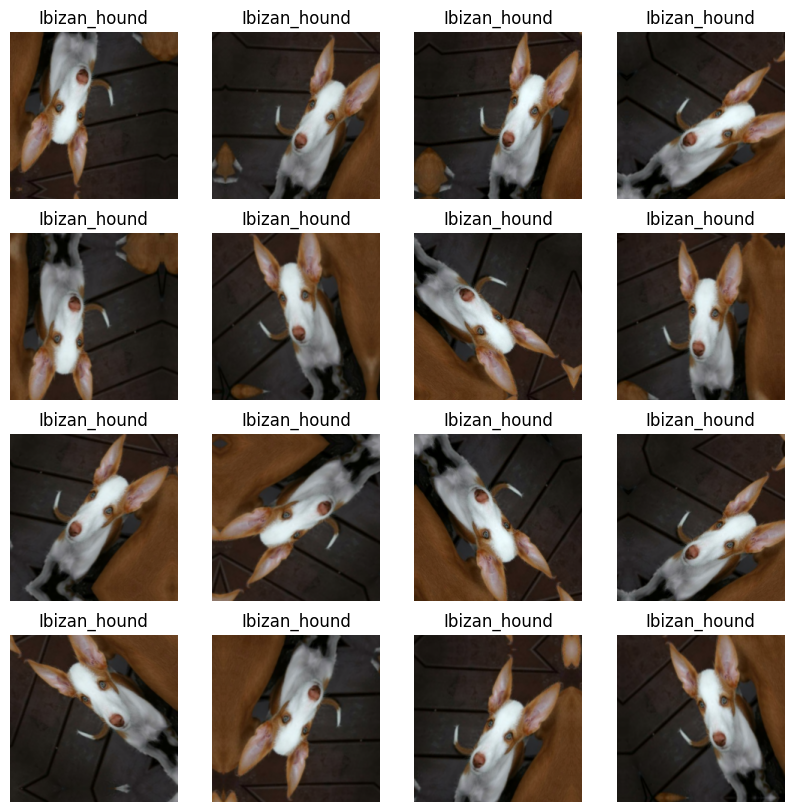

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8")) # Преобразуем картинку в тензор, теперь уже без NumPy
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")

### Предварительная обработка данных

После того как мы убедились, что входные данные и аугментация работают правильно, мы подготовим набор данных для обучения. Размер входных данных изменяется до единообразного IMG_SIZE. Метки помещаются в одноразовую (она же категориальная) кодировку. Набор данных сопоставлен.

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Вспомогательные функции

Напишем функцию для построения графиков и наглядной визуализации показателей обучения модели.

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Перенос обучения с предварительно обученных весов

Далее мы инициализируем модель с предварительно обученными весами ImageNet и с помощью тонкой настройки (fine-tune) настраиваем ее на нашем собственном наборе данных.

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B1(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

Первым шагом для переноса обучения является замораживание всех слоев и обучение только верхних слоев. Для этого шага можно использовать относительно большую скорость обучения (learning rate), даже до `1e-2`. Обратите внимание, что точность на проверочной выборке будут выше (потери ниже), чем на обучающей выборке. Это связано с высокой степенью регуляризации, которая подавляет метрики на этапе обучения.

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step - acc: 0.5805 - loss: 1.4307 - val_acc: 0.9667 - val_loss: 0.1308
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 160s 13s/step - acc: 0.8490 - loss: 0.6421 - val_acc: 0.9778 - val_loss: 0.0920
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 173s 14s/step - acc: 0.8848 - loss: 0.5154 - val_acc: 0.9750 - val_loss: 0.0946
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 210s 15s/step - acc: 0.8987 - loss: 0.4298 - val_acc: 0.9778 - val_loss: 0.1047
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 181s 13s/step - acc: 0.8992 - loss: 0.4260 - val_acc: 0.9750 - val_loss: 0.1022
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 176s 14s/step - acc: 0.9160 - loss: 0.3472 - val_acc: 0.9722 - val_loss: 0.0955
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 171s 14s/step - acc: 0.8980 - loss: 0.4065 - val_acc: 0.9778 - val_loss: 0.1123
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 206s 14s/step - acc: 0.9128 - loss: 0.3343 - val_acc: 0.9750 - val_loss: 0.1049
Epoch

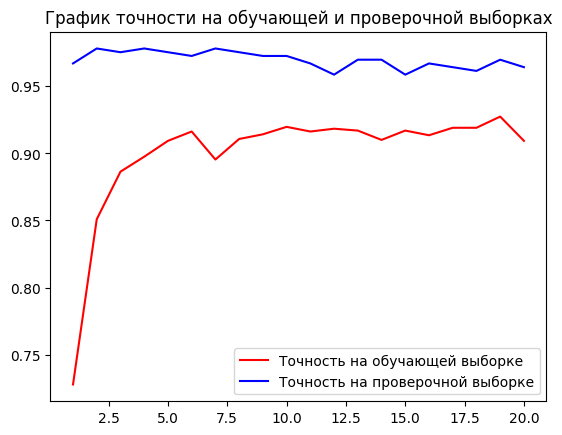

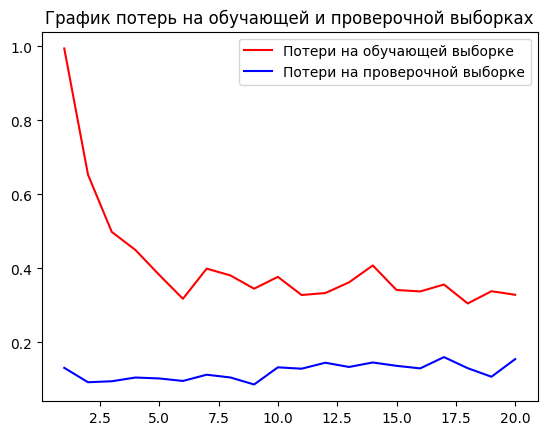

In [ ]:
show_plot(history)

Далее сохраним модель и автоматически скачаем сохраненную модель:

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Мы сохранили модель, так как в течение следующих 20 эпох Google Colab прервет наши вычисления, так как у нас закончится бесплатное время.

После этого можно загрузить, сохраненую ранее модель и продолжить обучение:

In [ ]:
model = keras.saving.load_model('best_model_pretrain.keras')

Так как модель по умолчанию сохраняется целиком, со всеми параметрами компиляции, то при загрузке (с параметрами по умолчанию), происходит ее автоматическая компиляция, и модель можно сразу обучать:

### Разморозка весов

Второй шаг заключается в разморозке несколько дополнительных слоев и подгонки модели, используя меньшую скорость обучения.

В этом примере мы показываем размораживание всех слоев (кроме нормализации на пакете), но в зависимости от конкретного набора данных может оказаться желательным разморозить только часть слоев.

Epoch 1/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - acc: 0.8831 - loss: 0.4701 - val_acc: 0.9778 - val_loss: 0.0882
Epoch 2/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - acc: 0.8846 - loss: 0.5451 - val_acc: 0.9778 - val_loss: 0.0855
Epoch 3/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.8943 - loss: 0.4797 - val_acc: 0.9778 - val_loss: 0.0838
Epoch 4/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.8826 - loss: 0.5023 - val_acc: 0.9778 - val_loss: 0.0827
Epoch 5/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.8961 - loss: 0.4716 - val_acc: 0.9778 - val_loss: 0.0822
Epoch 6/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - acc: 0.8712 - loss: 0.5843 - val_acc: 0.9778 - val_loss: 0.0821
Epoch 7/7
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.9094 - loss: 0.3769 - val_acc: 0.9778 - val_loss: 0.0824


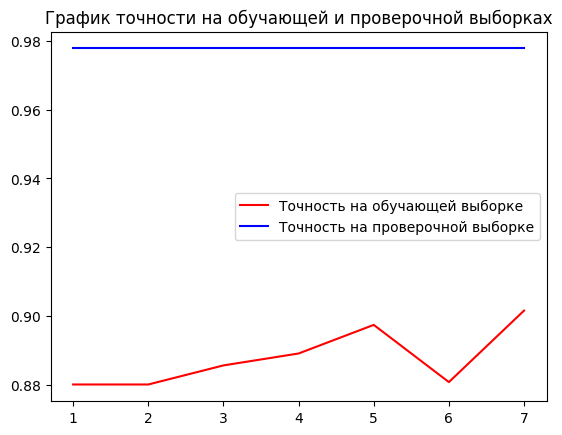

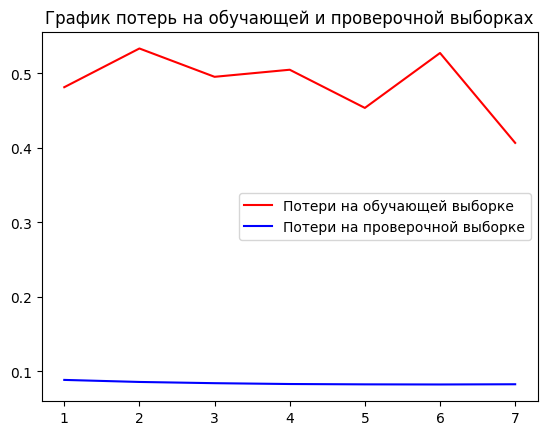

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 7
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

Таким образом, благодаря переносу обучения и тонкой настройки, мы обучили нашу модель предсказывать породу собак с вероятностью 98%, это отличный результат!

### Проверка модели

Проверим, как работает наша модель. Распознаем картинку, которую "не видела" наша модель.
Сгенерируем изображение с помощью библиотеки KerasCV.

In [ ]:
!pip install --upgrade keras-cv # установка библиотеки

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.0 MB/s eta 0:00:00


Ниже ячейка решает проблему зависимостей keras-cv и tensorflow, пока разработчики не внесут правки в официальный релиз библиотек.

In [ ]:
def fix_stable_diffusion():
    import keras_cv.src.models.stable_diffusion.text_encoder as text_encoder

    # Исправленная версия для CLIPAttention
    def fixed_clip_attention_call(self, inputs, attention_mask=None):
        batch_size, sequence_length = tf.shape(inputs)[0], tf.shape(inputs)[1]

        mixed_query_layer = self.q_proj(inputs)
        mixed_key_layer = self.k_proj(inputs)
        mixed_value_layer = self.v_proj(inputs)

        query_layer = tf.reshape(mixed_query_layer, [batch_size, sequence_length, self.num_heads, self.head_dim])
        query_layer = tf.transpose(query_layer, [0, 2, 1, 3])  # [batch, heads, seq, depth]

        key_layer = tf.reshape(mixed_key_layer, [batch_size, sequence_length, self.num_heads, self.head_dim])
        key_layer = tf.transpose(key_layer, [0, 2, 1, 3])  # [batch, heads, seq, depth]

        value_layer = tf.reshape(mixed_value_layer, [batch_size, sequence_length, self.num_heads, self.head_dim])
        value_layer = tf.transpose(value_layer, [0, 2, 1, 3])  # [batch, heads, seq, depth]

        scale = tf.cast(
            1.0 / tf.math.sqrt(tf.cast(self.head_dim, mixed_query_layer.dtype)),
            mixed_query_layer.dtype
        )
        attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True) * scale

        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        if getattr(self, "causal", False):
            # Создаем числовую причинную маску
            causal_mask = tf.ones((1, 1, sequence_length, sequence_length), dtype=attention_scores.dtype)
            causal_mask = tf.linalg.band_part(causal_mask, -1, 0)  # Нижняя треугольная части
            causal_mask = 1.0 - causal_mask  # Инвертируем для верхней треугольной части
            causal_mask = causal_mask * -1e9  # Большое отрицательное число для маскирования
            attention_scores = attention_scores + causal_mask

        attention_probs = tf.nn.softmax(attention_scores, axis=-1)
        context_layer = tf.matmul(attention_probs, value_layer)

        context_layer = tf.transpose(context_layer, [0, 2, 1, 3])  # [batch, seq, heads, depth]
        context_layer = tf.reshape(context_layer, [batch_size, sequence_length, self.embed_dim])

        outputs = self.out_proj(context_layer)
        return outputs

    # Заменяем метод call класса CLIPAttention
    text_encoder.CLIPAttention.call = fixed_clip_attention_call

    # Теперь проверяем, какие атрибуты действительно есть у CLIPEncoderLayer
    import inspect

    # Исправленная версия для CLIPEncoderLayer
    def fixed_clip_encoder_call(self, inputs):
        residual = inputs
        x = self.layer_norm1(inputs)
        x = self.clip_attn(x)
        x = residual + x

        residual = x
        x = self.layer_norm2(x)

        # Проверяем, какие атрибуты действительно используются
        # В оригинале, скорее всего, вместо mlp есть другой атрибут
        if hasattr(self, "mlp"):
            x = self.mlp(x)
        elif hasattr(self, "fc1"):
            # Типичная реализация MLP в трансформерах: fc1 -> активация -> fc2
            x = self.fc1(x)
            x = self.activation(x)
            x = self.fc2(x)
        elif hasattr(self, "ffn"):
            # Еще один вариант имени: ffn (feed-forward network)
            x = self.ffn(x)
        elif hasattr(self, "feed_forward"):
            x = self.feed_forward(x)
        # Добавьте больше вариантов по необходимости

        x = residual + x
        return x

    # Заменяем метод call класса CLIPEncoderLayer
    text_encoder.CLIPEncoderLayer.call = fixed_clip_encoder_call

    # Для диагностики выведем реальные атрибуты
    print("Доступные атрибуты CLIPEncoderLayer:", dir(text_encoder.CLIPEncoderLayer))

# Применяем патч
fix_stable_diffusion()

Доступные атрибуты CLIPEncoderLayer: ['__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_api_export_path', '_api_export_symbol_id', '_assert_input_compatibility', '_build_by_run_for_kwargs', '_build_by_run_for_single_pos_arg', '_check_quantize_args', '_check_super_called', '_checkpoint_adapter', '_checkpoint_dependencies', '_clear_losses', '_copy_trackable_to_cpu', '_default_save_signature', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_flatten_layers', '_float8_call', '_gather_saveables_for_checkpo

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 137s 650ms/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


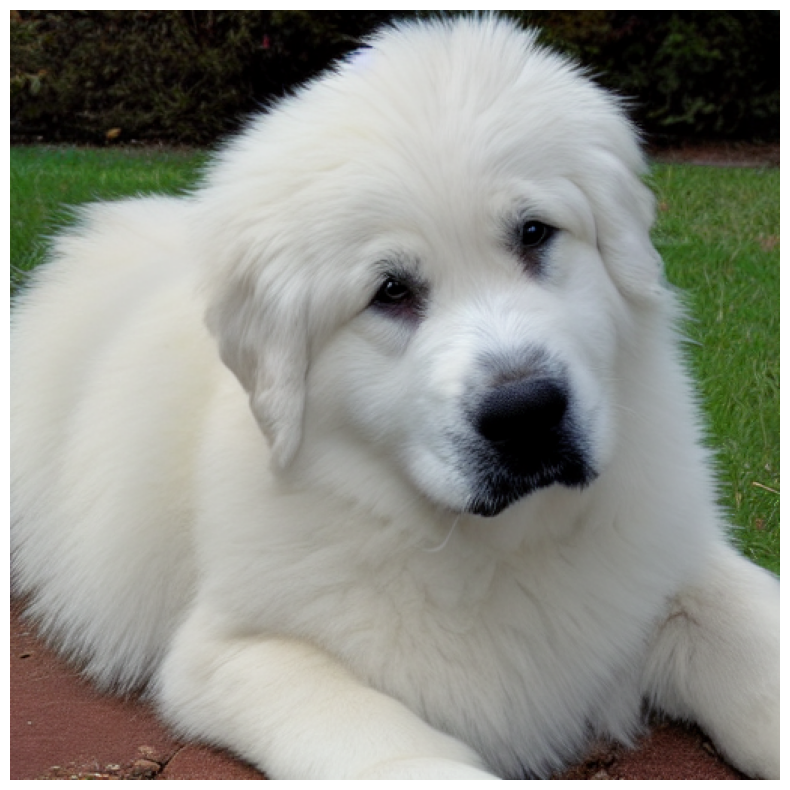

In [ ]:
import random
import keras_cv
import tensorflow as tf
from tensorflow import keras

# Выбираем случайную породу собаки из списка пород
dog_breed = random.sample(list_name, 1, counts=None)



keras.backend.clear_session() # Clear the TensorFlow session to release resources

# Check if test_model exists and reset it to avoid re-initialization error
if 'test_model' in globals() and test_model is not None:
    # Clear the existing model and its variables
    del test_model
    # Recreate the model
    test_model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)
else:
    test_model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

# Генерируем картинку по запросу
# img = test_model.text_to_image(f'{dog_breed[0]} dog breed', batch_size=1)

# Проверим работу модели на породе Great Pyrenees, она имеется в нашем сохранённом списке
img = test_model.text_to_image('Great Pyrenees dog breed', batch_size=1)

def plot_images(img):
    # plt.title(f'Собака породы {dog_breed[0]}')
    plt.figure(figsize=(10, 10))
    for i in range(len(img)):
        ax = plt.subplot(1, len(img), i + 1)
        plt.imshow(img[i])
        plt.axis("off")

# Выводим сгенерированное изображение
plot_images(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

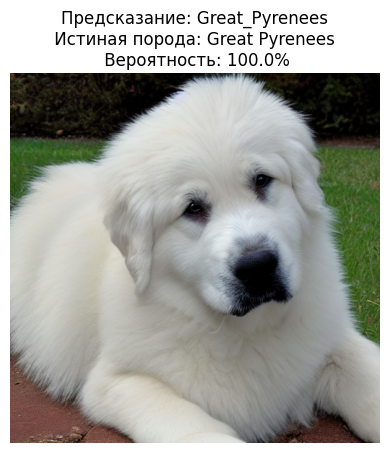

In [ ]:
img_array = tf.squeeze(img, axis=0)
plt.imshow(img_array)

img_array = tf.image.resize(img_array, [224, 224])

img_array = keras.ops.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)

plt.title("Предсказание: %s\n Истиная порода: Great Pyrenees \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

**ВЫВОД:** Отлично! Модель уверена на 100%, что на картинке изображена Great Pyrenees (Пиренейская горная собака). Так и есть!